# Корреляция и регрессия

Помимо сравнения двух и более групп хорошего аналитика часто интересуют взаимосвязи между двумя величинами — их значимость и сила. Для этих целей научимся пользоваться корреляционным и регрессионным анализом.

In [10]:
import numpy as np
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

**через numpy (только Пирсона, без p-значений)**
    
    np.corrcoef(x, y)  # y опционален, можно дать массив с несколькими колонками, функция строит матрицу корреляций

**через scipy (даёт значение коэффициента корреляции и p-значение)**
    
    st.pearsonr(x, y) 
    st.spearmanr(x, y)
    st.kendalltau(x, y) 

**через pandas (сравнение pandas Series)**

    df.corr()
    df.corr(method='spearman')
    df.corr(method='kendall')


Функцию np.corrcoef() имеет смысл использовать только в том случае, если у вас несколько переменных и вы хотите увидеть попарные корреляции каждой из них. 

На выходе тогда будет корреляционная матрица, по левой диагонали которой будут единицы (так как там переменная коррелируется сама с собой)

График корреляции называется диаграммой рассеяния (scatterplot). В Python его можно нарисовать следующим образом:

    sns.scatterplot(x = 'sepal_length', y = 'sepal_width', data = iris)
    plt.title('Взаимосвязь измерений чашелистников ирисов')
    plt.xlabel('Длина чашелистника')
    plt.ylabel('Ширина чашелистника')

Оцените регрессионную модель

In [9]:
url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/HistData/Guerry.csv"
dat = pd.read_csv(url)

# Fit regression model (using the natural log of one of the regressors)
results = smf.ols("Lottery ~ Literacy + np.log(Pop1831)", data=dat).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     22.20
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.90e-08
Time:                        13:02:00   Log-Likelihood:                -379.82
No. Observations:                  86   AIC:                             765.6
Df Residuals:                      83   BIC:                             773.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         246.4341     35.233     

**Регрессия с одной независимой переменной:**


через scipy (только одномерная)

    stats.linregress(x, y)

через statsmodels (один из вариантов)

    # Y = одномерный массив с ЗП, X - массив с НП
    X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
    model = sm.OLS(Y, X)  # говорим модели, что у нас ЗП, а что НП
    results = model.fit()  # строим регрессионную прямую
    print(results.summary())  # смотрим результат

то же самое можно через формулу

    results = smf.ols('Y ~ X', data).fit()
    print(results.summary())


**Нормальность остатков**

Тест Жарка-Бера:

    name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
    test = sms.jarque_bera(results.resid)
    lzip(name, test)
    
Всесторонний тест:

    name = ["Chi^2", "Two-tail probability"]
    test = sms.omni_normtest(results.resid)
    lzip(name, test)

Тесты на влияние

После создания объект класса OLSInfluence содержит атрибуты и методы, которые позволяют пользователям оценивать влияние каждого наблюдения. 

Например, мы можем вычислить и извлечь первые несколько строк DFbets следующим образом:

In [13]:
from statsmodels.stats.outliers_influence import OLSInfluence

test_class = OLSInfluence(results)
test_class.dfbetas[:5, :]


array([[-0.00301154,  0.00290872,  0.00118179],
       [-0.06425662,  0.04043093,  0.06281609],
       [ 0.01554894, -0.03556038, -0.00905336],
       [ 0.17899858,  0.04098207, -0.18062352],
       [ 0.29679073,  0.21249207, -0.3213655 ]])

Полезную информацию о кредитном плече также можно нанести на график:

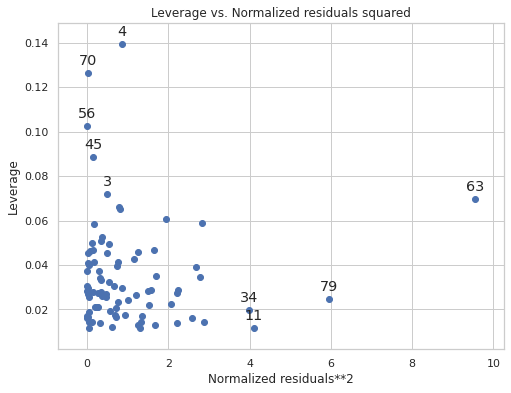

In [14]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

fig, ax = plt.subplots(figsize=(8, 6))
fig = plot_leverage_resid2(results, ax=ax)

https://www.statsmodels.org/stable/graphics.html

Мультиколлинеарность

In [15]:
np.linalg.cond(results.model.exog)

702.1792145490066

**Тесты на гетероскедастичность**

Тест Бреуша-Пэгана:

    name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
    test = sms.het_breuschpagan(results.resid, results.model.exog)
    lzip(name, test)

Тест Гольдфельда-Квандта:

    name = ["F statistic", "p-value"]
    test = sms.het_goldfeldquandt(results.resid, results.model.exog)
    lzip(name, test)

Линейность

Проверка множителя Харви-Коллиера для нулевой гипотезы о правильности линейной спецификации:

    name = ["t value", "p value"]
    test = sms.linear_harvey_collier(results)
    lzip(name, test)

Как визуализировать регрессию

График фактически идентичен тому, который строится при обычной корреляции, но в случае линейной регрессии принято ещё рисовать соответствующую прямую:

    sns.regplot(x = 'sepal_length', y = 'sepal_width', data = iris)
    plt.title('Взаимосвязь измерений чашелистников ирисов')
    plt.xlabel('Длина чашелистника')
    plt.ylabel('Ширина чашелистника')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


-1.0


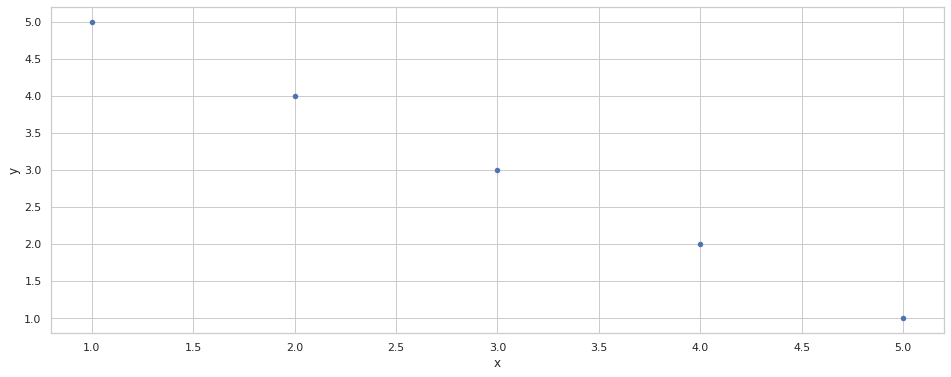

In [19]:
from math import sqrt

data = {'x': [4,5,2,3,1], 'y': [2,1,4,3,5]}
df = pd.DataFrame(data=data)

mean = df.mean(axis = 0)
rxy = sum((df['x'] - mean['x']) * (df['y'] - mean['y'])) / sqrt(sum((df['x'] - mean['x'])**2) * sum((df['y'] - mean['y'])**2))
print(rxy)
df.plot.scatter(x='x', y='y');

In [20]:
df.corr()

,x,y
x,1.0,-1.0
y,-1.0,1.0
